# Parametric umap autoencoder to visualize GAP layer data

## load GAP data

In [1]:
import torch
import math

import numpy as np
import torchvision
import torchvision.transforms as transforms
# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
from cifar10_models import *

In [2]:
INPUT_SIZE = 2048
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# load model
model = resnet50(pretrained=True)
model.eval()
model.to(device)
print("Load Model successfully...")

Load Model successfully...


In [4]:
# hyperparameters
data_shape = (2048,)

ADD_NOISE = False
n_hidden = 500
dim_img = INPUT_SIZE  # number of pixels for a MNIST image
dim_z = 2

# train
n_epochs = 500
batch_size = 200
learn_rate = 0.001

In [5]:
# CIFAR10 Test dataset and dataloader declaration
CIFAR_NORM = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(*CIFAR_NORM)])

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2000,
                                          shuffle=True, num_workers=2)
training_data = np.zeros((50000, 3, 32, 32))
for i, (data, target) in enumerate(trainloader, 0):
    r1, r2 = i * 2000, (i + 1) * 2000
    training_data[r1:r2] = data

raw_input_X = torch.from_numpy(training_data).to(device, dtype=torch.float)
input_X = np.zeros([len(raw_input_X), data_shape[0]])
n_batches = max(math.ceil(len(raw_input_X) / batch_size), 1)
for b in range(n_batches):
    r1, r2 = b * batch_size, (b + 1) * batch_size
    inputs = raw_input_X[r1:r2]
    with torch.no_grad():
        pred = model.gap(inputs).cpu().numpy()
        input_X[r1:r2] = pred
train_data = input_X    # (50000,2048)

train_data.shape

Files already downloaded and verified


(50000, 2048)

In [8]:
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2000,
                                          shuffle=True, num_workers=2)
testing_data = np.zeros((10000, 3, 32, 32))
for i, (data, target) in enumerate(testloader, 0):
    r1, r2 = i * 2000, (i + 1) * 2000
    testing_data[r1:r2] = data

raw_input_X = torch.from_numpy(testing_data).to(device, dtype=torch.float)
input_X = np.zeros([len(raw_input_X), data_shape[0]])
n_batches = max(math.ceil(len(raw_input_X) / batch_size), 1)
for b in range(n_batches):
    r1, r2 = b * batch_size, (b + 1) * batch_size
    inputs = raw_input_X[r1:r2]
    with torch.no_grad():
        pred = model.gap(inputs).cpu().numpy()
        input_X[r1:r2] = pred
test_data = input_X    # (10000,2048)

test_data.shape

Files already downloaded and verified


(10000, 2048)

## load parametric umap

In [9]:
from umap.parametric_umap import ParametricUMAP

In [10]:
# define encoder
import tensorflow as tf
dims = (2048,)
n_components = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 3,017,474
Trainable params: 3,017,474
Non-trainable params: 0
______________________________________________

In [11]:
# define the decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=np.product(dims), name="recon", activation=None),
    tf.keras.layers.Reshape(dims),

])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              525312    
_________________________________________________________________
recon (Dense)                (None, 2048)              2099200   
_________________________________________________________________
reshape (Reshape)            (None, 2048)              0         
Total params: 3,019,520
Trainable params: 3,019,520
Non-trainable params: 0
____________________________________________

In [13]:
# optimizer = tf.keras.optimizers.Adam(1e-3)
batch_size = 1000
# validation_data = train_data[-10000:]
train_data = train_data

keras_fit_kwargs = {"callbacks": [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=10**-2,
        patience=10,
        verbose=1,
    )
]}

train_data.shape

(50000, 2048)

In [14]:
embedder = ParametricUMAP(
    encoder=encoder,
    decoder=decoder,
    dims=dims,
    parametric_reconstruction=True,
#     reconstruction_validation=validation_data,
    autoencoder_loss=True,
    n_training_epochs=100,
    keras_fit_kwargs = keras_fit_kwargs,
    verbose=True,
)

## fit model

In [15]:
embedding = embedder.fit_transform(train_data)

ParametricUMAP(autoencoder_loss=True,
               decoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001F3E5C6A3C8>,
               dims=(2048,),
               encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001F3E5C1F320>,
               keras_fit_kwargs={'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping object at 0x000001F3E5C488D0>]},
               n_training_epochs=100,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001F3E5C48D30>,
               parametric_reconstruction=True)
Construct fuzzy simplicial set
Mon Nov 30 11:44:42 2020 Finding Nearest Neighbors
Mon Nov 30 11:44:42 2020 Building RP forest with 16 trees
Mon Nov 30 11:44:45 2020 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Mon Nov 30 11:44:58 2020 Finished Nearest Neighbor Search
Mon Nov 30 11:45:00 2020 Construct embedding


D:\Downloads\anaconda\envs\DR2\lib\site-packages\umap\parametric_umap.py:270: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Epoch 1/1000
644/644 [==============================] - 83s 127ms/step - loss: 0.3369 - reconstruction_loss: 0.1553 - umap_loss: 0.1817
Epoch 2/1000
644/644 [==============================] - 82s 127ms/step - loss: 0.1918 - reconstruction_loss: 0.0971 - umap_loss: 0.0947
Epoch 3/1000
644/644 [==============================] - 85s 131ms/step - loss: 0.1849 - reconstruction_loss: 0.0955 - umap_loss: 0.0894
Epoch 4/1000
644/644 [==============================] - 85s 132ms/step - loss: 0.1812 - reconstruction_loss: 0.0942 - umap_loss: 0.0870
Epoch 5/1000
644/644 [==============================] - 85s 133ms/step - loss: 0.1808 - reconstruction_loss: 0.0939 - umap_loss: 0.0868
Epoch 6/1000
644/644 [==============================] - 85s 132ms/step - loss: 0.1794 - reconstruction_loss: 0.0937 - umap_loss: 0.0857
Epoch 7/1000
644/644 [==============================] - 86s 133ms/step - loss: 0.1788 - reconstruction_loss: 0.0937 - umap_loss: 0.0851
Epoch 8/1000
644/644 [==========================

In [14]:
# embedder.save('./parametric_umap_models/parametric_umap_autoencoder',verbose=True)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ./parametric_umap_models/parametric_umap_autoencoder\encoder\assets
Keras encoder model saved to ./parametric_umap_models/parametric_umap_autoencoder\encoder

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ./parametric_umap_models/parametric_umap_autoencoder\decoder\assets
Keras decoder model saved to ./parametric_umap_models/parametric_umap_autoencoder\decoder

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecat

AttributeError: Can't pickle local object 'ParametricUMAP._define_model.<locals>.<lambda>'

## eval local structure preserving

### trustworthiness

In [16]:
train_data.shape, test_data.shape

((50000, 2048), (10000, 2048))

In [17]:
from sklearn.manifold import trustworthiness

In [18]:
train_embedded = embedder.transform(train_data)
t = trustworthiness(train_data, train_embedded, n_neighbors=10, metric='euclidean')
t

50/50 [==============================] - 1s 14ms/step


0.9848552585301443

In [19]:
test_embedded = embedder.transform(test_data)
embedded_t = trustworthiness(test_data, test_embedded, n_neighbors=10, metric='euclidean')
embedded_t

10/10 [==============================] - 8s 43ms/step


0.9828336862136311

In [ ]:
total_data = np.concatenate((train_data, test_data),axis=0)
total_embedded = embedder.transform(total_data)
total_t = trustworthiness(total_data, total_embedded, n_neighbors=10, metric='euclidean')
total_t

60/60 [==============================] - 1s 19ms/step


In [ ]:
import matplotlib.pyplot as plt
# Project data
z = embedder.transform(train_data)

fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
#     c=train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("parametric UMAP autoencoder embeddings-training data", fontsize=20)

In [ ]:
# Project data
z = embedder.transform(test_data)

fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
#     c=train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("parametric UMAP autoencoder embeddings-testing data", fontsize=20)

In [ ]:
# Project data
z = embedder.transform(np.concatenate((train_data, test_data),axis=0))

fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
#     c=train_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("parametric UMAP autoencoder embeddings-total data", fontsize=20)

## inverse

In [ ]:
test_num = 50000
adv_succ_num = 4000 # max 
adv_fail_num = 4000 # max
true_num = 10000
softmax = torch.nn.Softmax(dim=-1)

def pred_wrapper(x):
    with torch.no_grad():
        # tensor = torch.from_numpy(x).to(device, dtype=torch.float)
        logits = model.fc(x)
        probabilities = softmax(logits).cpu().numpy()
    return probabilities

# ---------------------load data------------------------------
test_samples = training_data[:test_num]
true_samples = testing_data[:true_num]

Adv_succ = np.load("adv_testset\\succ.npy")
Adv_fail = np.load("adv_testset\\fail.npy")

adv_succ = torch.from_numpy(Adv_succ[-adv_succ_num:]).to(device, dtype=torch.float)
adv_fail = torch.from_numpy(Adv_fail[-adv_fail_num:]).to(device, dtype=torch.float)

raw_input_X = torch.from_numpy(test_samples).to(device, dtype=torch.float)
raw_input_X = torch.cat((raw_input_X, adv_succ), axis=0)
raw_input_X = torch.cat((raw_input_X, adv_fail), axis=0)
raw_input_X = torch.cat((raw_input_X, true_samples), axis=0)

input_X = np.zeros([len(raw_input_X), data_shape[0]])
output_Y = np.zeros(len(raw_input_X))
n_batches = max(math.ceil(len(raw_input_X) / batch_size), 1)
for b in range(n_batches):
    r1, r2 = b * batch_size, (b + 1) * batch_size
    inputs = raw_input_X[r1:r2]
    with torch.no_grad():
        pred = model.gap(inputs).cpu().numpy()
        input_X[r1:r2] = pred
        pred = pred_wrapper(torch.from_numpy(pred).to(device, dtype=torch.float)).argmax(axis=1)
        output_Y[r1:r2] = pred

embedded = embedder.transform(input_X)
y_PRR = embedder.inverse_transform(embedded)
# y_PRR, embedded = ae.get_ae(encoder, decoder, torch.from_numpy(input_X).float().to(device), batch_size)
# y_PRR = y_PRR.detach().numpy()

# pick samples for training and testing
train_samples = input_X[:test_num]
train_labels = output_Y[:test_num]
test_adv_succ = input_X[test_num:test_num + adv_succ_num]
test_adv_succ_labels = output_Y[test_num:test_num + adv_succ_num]
test_adv_fail = input_X[test_num + adv_succ_num:test_num + adv_succ_num + adv_fail_num]
test_adv_fail_labels = output_Y[test_num + adv_succ_num:test_num + adv_succ_num + adv_fail_num]
test_true = input_X[-true_num:]
test_true_labels = output_Y[-true_num:]
# apply inverse mapping to embedded samples and
# predict the reconstructions
train_recon = y_PRR[:test_num]
train_recon_preds = pred_wrapper(torch.from_numpy(train_recon).to(device, dtype=torch.float)).argmax(axis=1)
train_confidence = pred_wrapper(torch.from_numpy(train_samples).to(device, dtype=torch.float)).max(axis=1)
train_new_confidence = pred_wrapper(torch.from_numpy(train_recon).to(device, dtype=torch.float)).max(axis=1)

adv_succ_recon = y_PRR[test_num:test_num + adv_succ_num]
adv_succ_recon_preds = pred_wrapper(torch.from_numpy(adv_succ_recon).to(device, dtype=torch.float)).argmax(
    axis=1)
adv_succ_confidence = pred_wrapper(torch.from_numpy(test_adv_succ).to(device, dtype=torch.float)).max(
    axis=1)
adv_succ_new_confidence = pred_wrapper(torch.from_numpy(adv_succ_recon).to(device, dtype=torch.float)).max(
    axis=1)

adv_fail_recon = y_PRR[test_num + adv_succ_num:test_num + adv_succ_num + adv_fail_num]
adv_fail_recon_preds = pred_wrapper(torch.from_numpy(adv_fail_recon).to(device, dtype=torch.float)).argmax(
    axis=1)
adv_fail_confidence = pred_wrapper(torch.from_numpy(test_adv_fail).to(device, dtype=torch.float)).max(
    axis=1)
adv_fail_new_confidence = pred_wrapper(torch.from_numpy(adv_fail_recon).to(device, dtype=torch.float)).max(
    axis=1)

true_recon = y_PRR[-true_num:]
true_recon_preds = pred_wrapper(torch.from_numpy(true_recon).to(device, dtype=torch.float)).argmax(axis=1)
true_confidence = pred_wrapper(torch.from_numpy(test_true).to(device, dtype=torch.float)).max(axis=1)
true_new_confidence = pred_wrapper(torch.from_numpy(true_recon).to(device, dtype=torch.float)).max(axis=1)

# calculate pred accuracy
n_correct = np.sum(train_labels == train_recon_preds)
train_acc = 100 * n_correct / test_num

n_correct = np.sum(test_adv_succ_labels == adv_succ_recon_preds)
test_adv_succ_acc = 100 * n_correct / float(adv_succ_num)

n_correct = np.sum(test_adv_fail_labels == adv_fail_recon_preds)
test_adv_fail_acc = 100 * n_correct / float(adv_fail_num)

n_correct = np.sum(test_true_labels == true_recon_preds)
test_true_acc = 100 * n_correct / float(true_num)

# calculate distance
train_distance = np.mean(np.sqrt(np.sum(np.square(train_samples - train_recon), axis=1)))
adv_succ_distance = np.mean(np.sqrt(np.sum(np.square(test_adv_succ - adv_succ_recon), axis=1)))
adv_fail_distance = np.mean(np.sqrt(np.sum(np.square(test_adv_fail - adv_fail_recon), axis=1)))
true_distance = np.mean(np.sqrt(np.sum(np.square(test_true - true_recon), axis=1)))

# calculate confidence difference
train_conf_diff = np.mean(np.abs(train_confidence - train_new_confidence))
adv_succ_conf_diff = np.mean(np.abs(adv_succ_confidence - adv_succ_new_confidence))
adv_fail_conf_diff = np.mean(np.abs(adv_fail_confidence - adv_fail_new_confidence))
true_conf_diff = np.mean(np.abs(true_confidence - true_new_confidence))

print("train acc:{:.2f}%, test_succ acc:{:.2f}%, test_fail acc:{:.2f}%, test_true acc:{:.2f}%".format(
    train_acc,
    test_adv_succ_acc,
    test_adv_fail_acc,
    test_true_acc))

print("train distance:{:.2f}, test_succ dis:{:.2f}, test_fail dis:{:.2f}, test_true dis:{:.2f}".format(
    train_distance,
    adv_succ_distance,
    adv_fail_distance,
    true_distance))
print(
    "train con diff:{:.2f}, test_succ con dif:{:.2f}, test_fail con diff:{:.2f}, test_true con diff:{:.2f}".format(
        train_conf_diff,
        adv_succ_conf_diff,
        adv_fail_conf_diff,
        true_conf_diff))

In [16]:
true_confidence = pred_wrapper(torch.from_numpy(test_true).to(device, dtype=torch.float)).max(axis=1)
true_new_confidence = pred_wrapper(torch.from_numpy(true_recon).to(device, dtype=torch.float)).max(axis=1)
test_true,true_recon,true_confidence, true_new_confidence

(array([[2.24464457e-05, 1.18806839e-01, 1.91824138e-02, ...,
         7.12189749e-02, 0.00000000e+00, 5.84107824e-04],
        [4.93609114e-04, 6.57476438e-03, 7.72310561e-03, ...,
         1.51221373e-03, 0.00000000e+00, 1.09400717e-05],
        [1.18356664e-02, 5.96838910e-03, 3.03422183e-01, ...,
         4.49039554e-03, 3.07281408e-03, 1.70014165e-02],
        ...,
        [3.79591226e-03, 2.61280060e-01, 1.68406207e-03, ...,
         5.30657433e-02, 0.00000000e+00, 0.00000000e+00],
        [9.02255252e-03, 5.92675619e-03, 3.36675823e-01, ...,
         1.21193682e-03, 3.69105255e-03, 1.50678279e-02],
        [0.00000000e+00, 9.76955444e-02, 0.00000000e+00, ...,
         4.82328273e-02, 0.00000000e+00, 5.50889410e-02]]),
 array([[-5.9763203, -2.5881884, -5.224879 , ..., -2.5188477, -4.730977 ,
         -5.0103736],
        [-6.8242946, -5.548279 , -7.0154877, ..., -6.782976 , -6.996356 ,
         -7.970709 ],
        [-4.75567  , -5.3914866, -0.8326197, ..., -5.792511 , -4.7953076,

## Plot metric

### training loss

{'loss': [0.23149721324443817, 0.19227854907512665, 0.18922977149486542, 0.18519651889801025, 0.18418648838996887, 0.18199673295021057, 0.18077556788921356, 0.18097063899040222, 0.18086418509483337, 0.1812390387058258, 0.18028536438941956, 0.1795811504125595, 0.17900389432907104, 0.17854735255241394, 0.17918893694877625, 0.17731943726539612], 'reconstruction_loss': [0.10992393642663956, 0.09523361176252365, 0.0958896055817604, 0.09429077059030533, 0.09416545927524567, 0.09398489445447922, 0.0938488319516182, 0.09391828626394272, 0.09372079372406006, 0.09435935318470001, 0.0937972217798233, 0.09366452693939209, 0.09362693876028061, 0.09360148757696152, 0.09357178956270218, 0.09343650937080383], 'umap_loss': [0.12157342582941055, 0.09704484045505524, 0.09334011375904083, 0.09090562164783478, 0.09002089500427246, 0.08801175653934479, 0.08692678809165955, 0.08705238252878189, 0.08714330196380615, 0.08687962591648102, 0.08648820966482162, 0.08591663837432861, 0.08537700027227402, 0.08494593

Text(0.5, 0, 'Epoch')

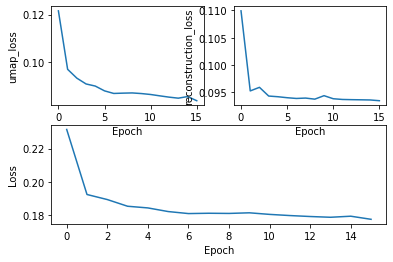

In [17]:
# plotting loss
import matplotlib.pyplot as plt
print(embedder._history)

# loss
ax1 = plt.subplot(212)
ax1.plot(embedder._history['loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

#umap_loss
ax2 = plt.subplot(221)
ax2.plot(embedder._history['umap_loss'])
ax2.set_ylabel('umap_loss')
ax2.set_xlabel('Epoch')

# reconstruction loss
ax3 = plt.subplot(222)
ax3.plot(embedder._history['reconstruction_loss'])
ax3.set_ylabel('reconstruction_loss')
ax3.set_xlabel('Epoch')

### validation loss

KeyError: 'val_loss'

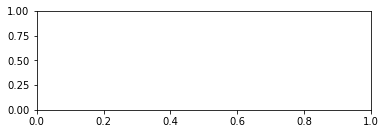

In [18]:
plt.cla()
# loss
ax1 = plt.subplot(212)
ax1.plot(embedder._history['val_loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')


# reconstruction loss
ax3 = plt.subplot(211)
ax3.plot(embedder._history['val_reconstruction_loss'])
ax3.set_ylabel('val_reconstruction_loss')
ax3.set_xlabel('Epoch')

# load parametric umap

In [31]:
from umap.parametric_umap import load_ParametricUMAP
new_embedder = load_ParametricUMAP('./parametric_umap_models/parametric_umap_autoencoder',verbose=True)

EOFError: Ran out of input